# Homework 03
## 1. NumPy performance

In [1]:
import numpy as np
import math

In [2]:
# expand this function to complete the first task of the first homework exercise
def log_integral(x, delta_x, N):
    _sum = 0
    for xk in x:
        ln_xk = math.log(xk)
        _sum += (ln_xk * delta_x) / ((1.0 + ln_xk)**2)
    return _sum

In [3]:
# expand this function to complete the second task of the first homework exercise
def log_integral_numpy(x, delta_x, N):
    if isinstance(x, list):
        x_array = np.array(x)
    elif isinstance(x, numpy.ndarray):
        x_array = x
    else:
        raise TypeError("x should be an array or a list!")
    term = np.log(x_array) * delta_x / ((1.0 + np.log(x_array))**2)
    return np.sum(term)

In [4]:
# change the variables c, N and x to complete the last task of this homework exercise

c = np.exp(1.0)
N = 10000
delta_x = (c-1)/N

x = list(np.arange(1, c, delta_x))


In [5]:
# this function test if your implementation of log_integral and log_integral_numpy are working correctly. It also prints the execution time of your implementations. If this function throws an NotImplementedError exceptions you still need to change your code in the cells above
# DO NOT REMOVE THIS FUNCTION
def test_log_integral(func, x, delta_x, N, printExecTime=True, verbose=False, decimal=4):
    if len(x) == 0: raise NotImplementedError("you need to define the partition!")
    if N == 1:      raise NotImplementedError("you should set the number of steps!")

    from numpy.testing import assert_almost_equal

    c = np.exp(1)

    test_value = np.exp(1)/2-1

    func_result = func(x, delta_x, N)

    print()
    if printExecTime:
        %timeit func(x, delta_x, N)

    if func_result == None:
        raise NotImplementedError('function "%s" still needs to be implemented!' % (func.__name__))
    
    try: 
        assert_almost_equal(func_result, test_value, decimal)
        print("[%s] test passed" % func.__name__)
    except:
        print("[%s] test did not pass" % func.__name__)
        verbose = True

    if verbose:
        print('function result: %.*f' % (decimal, func_result))
        print("expected result: %.*f" % (decimal, test_value))

In [6]:
# this calls the test function to see that everything works. DO NOT REMOVE THESE TWO LINES
test_log_integral(log_integral, x, delta_x, N)
test_log_integral(log_integral_numpy, x, delta_x, N)


4.46 ms ± 68.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
[log_integral] test passed

675 µs ± 18.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
[log_integral_numpy] test passed


## 2. House price Data Challenge

In [1]:
import pandas as pd
import numpy as np
import math
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn import ensemble
import matplotlib.pyplot as plt

In [2]:
df_train = pd.read_csv("train.csv")
df_test  = pd.read_csv("test.csv")

def preprocessDataFrame(df):
    df['garage'] = df['garage'].fillna(0)
    df['yrremodeled'] = df['yrremodeled'].fillna(0)

    # replace string label by numberical label
    dic = {'Farm': 1, 'Ranch':2, 'Cottage': 3, 'Town':4, 'Detached':5, 'Bungalow':6}

    df['housetype'] = df['housetype'].map(dic)

preprocessDataFrame(df_train)
preprocessDataFrame(df_test)

print(df_train.head(10))

   id  zipcode  floors  housetype  garage  lotarea  livingarea  Nbathroom  \
0   1    27131       1          6     0.0     1386         692          1   
1   2    27131       2          4   198.0     1950        1963          3   
2   3    27134       2          4     0.0      706        1053          1   
3   4    27119       3          3     0.0     1189        1808          3   
4   5    27119       2          5   245.0     2330        2845          2   
5   6    27137       2          4     0.0      928        1058          2   
6   7    27137       2          3   229.0     2320        2521          2   
7   8    27133       3          3     0.0     1750        2497          3   
8   9    27133       2          3     0.0     1415        2397          2   
9  10    27115       2          1     0.0     1367        1380          1   

   yearbuilt  yrremodeled  yearsale  monthsale   price  
0       1976          0.0      1996          1  162000  
1       1977          0.0      1996   

Convert data frame to numpy arrays

In [3]:
# we choose only importent features
# more see below
train_feat = df_train.loc[:,['housetype', 'garage', 'livingarea', 'Nbathroom', 'yearbuilt', 
                           'yrremodeled', 'yearsale', 'monthsale']].values
train_target = df_train.loc[:, ['price']].values[:, 0]

Use 90% of the data as training set and 10% as testing set (selected randomly)

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(train_feat, train_target, 
                                                   train_size=0.9, test_size=0.1, 
                                                   random_state=188)

Use GBDT to fit the data

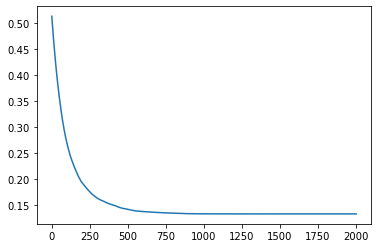

min abs error 0.13345859545775174 at 1027
weight for each feature [0.02180527 0.15622296 0.63106657 0.03770783 0.08689857 0.02669754
 0.02994814 0.0096531 ]
abs error for test set 0.13350843964892978


In [6]:
# number of iteration
N = 2000

params = {'n_estimators': N, 'max_depth': 4, 'min_samples_split':2, 
         'learning_rate': 0.01, 'loss': 'lad'}

gbr = ensemble.GradientBoostingRegressor(**params)
gbr.fit(X_train, Y_train)
# show the abs erros for each iteration
# this will help us to choose a good number of iteration
# the abs errors is not always reduced when N larger
errs = []
for y_pred in gbr.staged_predict(X_test):
    err = np.mean(np.abs(Y_test-y_pred) / Y_test)
    errs.append(err)
plt.figure()
plt.plot(np.arange(1,N+1), errs)
plt.show()
print("min abs error " + str(np.min(errs)) + " at " + str(np.where(np.array(errs) == np.min(errs))[0][0]))
y_pred = gbr.predict(X_test)
# show the weight for each feature
# when the weight is so small, we should not use this
# feature
# because it means that the house price only weak correlated
# or not correlated to this feature
print("weight for each feature " + str(gbr.feature_importances_))
print("abs error for test set " + str(np.mean(np.abs(Y_test-y_pred) / Y_test)))

Create submission file

In [9]:
# create submission
selected_columns = ['housetype', 'garage', 'livingarea', 'Nbathroom', 'yearbuilt', 
                           'yrremodeled', 'yearsale', 'monthsale']

df_test['price'] = gbr.predict(df_test[selected_columns])

df_test[['id','price']].to_csv('Wenjie_Wu_Dong_Zhang_submission.csv', index=False)